# FOREX Adviser - EURUSD Data
Important notes:
- The data on some minutes may be missing, e.g. 2001-01-02 23:17:00 to 23:19:00 are non existent.
- The open, high, low, and close can be different values within a single row (you may be tempted to think that they are always the same within each minute, but they are not).
- Seasonality might indicate the optimal time window to be used for input.

## Data Import

In [1]:
import pandas as pd

df = pd.read_csv('data/EURUSD.csv',
                    dtype={'<DTYYYYMMDD>': str,'<TIME>': str},
                    parse_dates={'date_time_index': ['<DTYYYYMMDD>', '<TIME>']},
                    index_col=['date_time_index']
                )
df = df.rename(columns={'<TICKER>': 'ticker',
                       '<OPEN>': 'open',
                       '<HIGH>': 'high',
                       '<LOW>': 'low',
                       '<CLOSE>': 'close',
                       '<VOL>': 'vol'})
df = df.drop(columns='ticker')

In [2]:
df.head()

,open,high,low,close,vol
date_time_index,,,,,
2001-01-02 23:01:00,0.9507,0.9507,0.9507,0.9507,4
2001-01-02 23:02:00,0.9506,0.9506,0.9505,0.9505,4
2001-01-02 23:03:00,0.9505,0.9507,0.9505,0.9506,4
2001-01-02 23:04:00,0.9506,0.9506,0.9506,0.9506,4
2001-01-02 23:05:00,0.9506,0.9506,0.9506,0.9506,4


In [3]:
df.tail()

,open,high,low,close,vol
date_time_index,,,,,
2020-08-31 23:55:00,1.1936,1.1936,1.1936,1.1936,4
2020-08-31 23:56:00,1.1935,1.1935,1.1935,1.1935,4
2020-08-31 23:57:00,1.1935,1.1935,1.1935,1.1935,4
2020-08-31 23:58:00,1.1936,1.1936,1.1936,1.1936,4
2020-08-31 23:59:00,1.1937,1.1937,1.1937,1.1937,4


In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6952310 entries, 2001-01-02 23:01:00 to 2020-08-31 23:59:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    6952310 non-null  float64
 1   high    6952310 non-null  float64
 2   low     6952310 non-null  float64
 3   close   6952310 non-null  float64
 4   vol     6952310 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 318.3 MB


## Close Prices Overall
- The close prices per minute is not stationary.

<AxesSubplot:xlabel='date_time_index'>

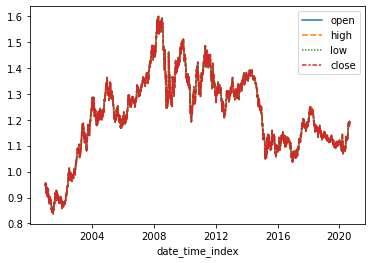

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df.iloc[0::1000, 0:-1])


<AxesSubplot:>

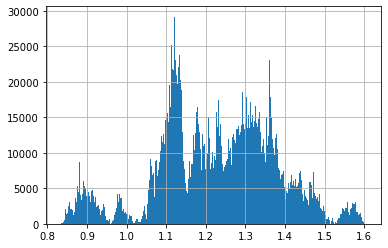

In [6]:
df['close'].hist(bins=1000)

## Diff of Close Price and Stationarity Analysis
- The diff of close price is indeed stationary.
- However, since the diff is based on close prices per minute, the diff is too small.
- It is then decided to change the bucket size to be 4 hours.

<AxesSubplot:xlabel='date_time_index', ylabel='close'>

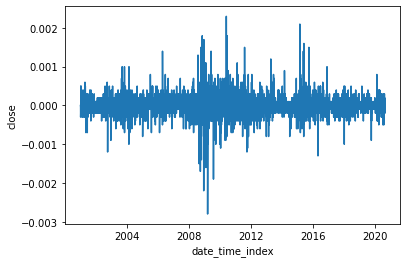

In [7]:
diff = df['close'].diff()
sns.lineplot(data=diff.iloc[0::1000])

<AxesSubplot:>

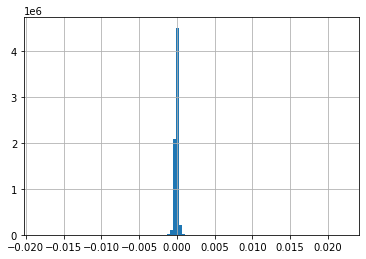

In [8]:
diff.hist(bins = 100)

<AxesSubplot:>

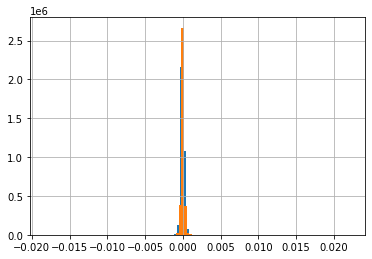

In [9]:
split = round(len(diff)/2)
diff[:split].hist(bins = 100)
diff[split:].hist(bins = 100)

## Bucketing the close prices to 4 hours
- The diff is still stationary.
- However, the mean of the diff is practically zero, with very small standard deviation as well. This gives concern where the generated model later on might only predict next price being equal to current price.

In [10]:
import math
import datetime

hours_per_bucket = 4

def ceil_datetimeindex_nearest_minute(dt, mnt):
    dt = dt.to_pydatetime()
    new_minute = math.ceil(dt.minute / mnt) * mnt
    new_dt = dt + datetime.timedelta(minutes = new_minute - dt.minute)
    return new_dt

def ceil_datetimeindex_nearest_hour(dt, hour):
    dt = dt.to_pydatetime()
    new_hour = math.ceil((dt.hour + (1 if dt.minute > 0 else 0)) / hour) * hour
    new_dt = dt + datetime.timedelta(hours = new_hour - dt.hour)
    new_dt = new_dt.replace(minute=0, second=0)
    return new_dt

df_aggregated = df.groupby(lambda x : ceil_datetimeindex_nearest_hour(x, hours_per_bucket)).aggregate({'open':'first', 'high':'max', 'low':'min', 'close':'last'})

Mean: 0.000008
Std: 0.003010
Mean (first half): 0.000029
Std (first half): 0.003282
Mean (second half): -0.000014
Std (second half): 0.002710
Mean difference percentage from first half: 146.78


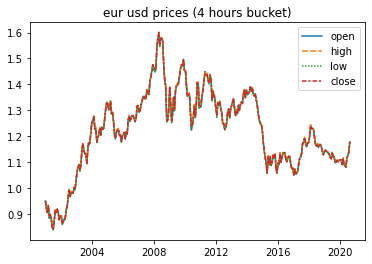

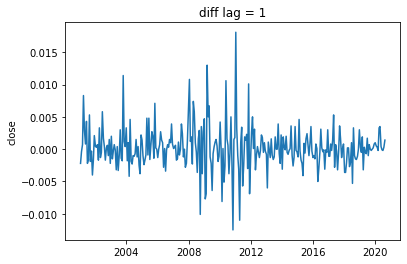

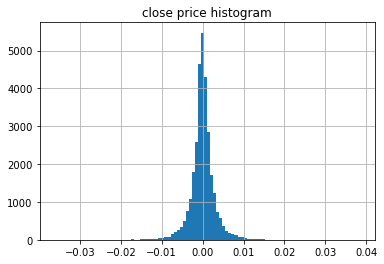

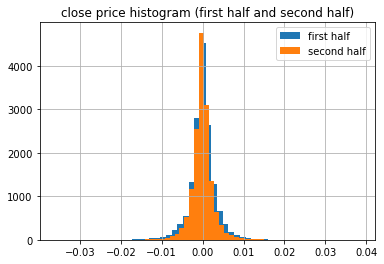

In [11]:
sns.lineplot(data=df_aggregated.iloc[0::100])
plt.title('eur usd prices (%d hours bucket)' % hours_per_bucket)

diff_agg = df_aggregated['close'].diff()

plt.figure()
plt.title('diff lag = 1')
sns.lineplot(data = diff_agg.iloc[0::100])

plt.figure()
plt.title('close price histogram')
diff_agg.hist(bins = 100)
print('Mean: %.6f' % diff_agg.mean())
print('Std: %.6f' % diff_agg.std())

plt.figure()
split = round(len(diff_agg)/2)
diff_agg[:split].hist(bins = 50)
print('Mean (first half): %.6f' % diff_agg[:split].mean())
print('Std (first half): %.6f' % diff_agg[:split].std())
diff_agg[split:].hist(bins = 50)
plt.title('close price histogram (first half and second half)')
plt.legend(['first half', 'second half'])
print('Mean (second half): %.6f' % diff_agg[split:].mean())
print('Std (second half): %.6f' % diff_agg[split:].std())
print('Mean difference percentage from first half: %0.2f' % (abs(diff_agg[:split].mean() - diff_agg[split:].mean()) / diff_agg[:split].mean() * 100))

Mean: 0.000015
Std: 0.004180
Mean (first half): 0.000055
Std (first half): 0.004575
Mean (second half): -0.000025
Std (second half): 0.003743
Mean difference percentage from first half: 146.04


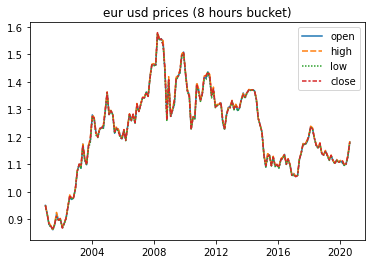

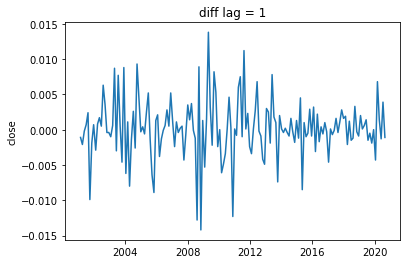

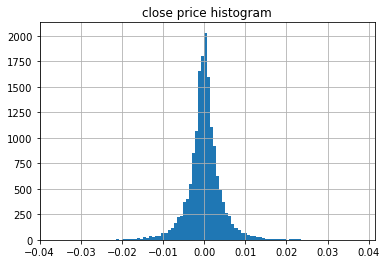

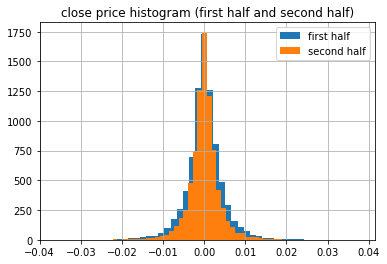

In [12]:
hours_per_bucket = 8
df_aggregated = df.groupby(lambda x : ceil_datetimeindex_nearest_hour(x, hours_per_bucket)).aggregate({'open':'first', 'high':'max', 'low':'min', 'close':'last'})

sns.lineplot(data=df_aggregated.iloc[0::100])
plt.title('eur usd prices (%d hours bucket)' % hours_per_bucket)

diff_agg = df_aggregated['close'].diff()

plt.figure()
plt.title('diff lag = 1')
sns.lineplot(data = diff_agg.iloc[0::100])

plt.figure()
plt.title('close price histogram')
diff_agg.hist(bins = 100)
print('Mean: %.6f' % diff_agg.mean())
print('Std: %.6f' % diff_agg.std())

plt.figure()
split = round(len(diff_agg)/2)
diff_agg[:split].hist(bins = 50)
print('Mean (first half): %.6f' % diff_agg[:split].mean())
print('Std (first half): %.6f' % diff_agg[:split].std())
diff_agg[split:].hist(bins = 50)
plt.title('close price histogram (first half and second half)')
plt.legend(['first half', 'second half'])
print('Mean (second half): %.6f' % diff_agg[split:].mean())
print('Std (second half): %.6f' % diff_agg[split:].std())
print('Mean difference percentage from first half: %0.2f' % (abs(diff_agg[:split].mean() - diff_agg[split:].mean()) / diff_agg[:split].mean() * 100))

## Difference between close and open of subsequent period of 4 hours bucketed

From below graph we can conclude that difference between open and close of subsequent period is not important.

mean-3.094931666359965e-06
std0.0007199003680772514


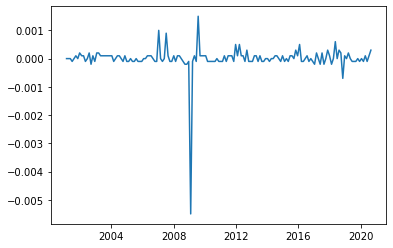

In [13]:
open_close_diff = (df_aggregated['open'] - df_aggregated['close'].shift(1))
sns.lineplot(data=open_close_diff[0::100])
print('mean' + str(open_close_diff.mean()))
print('std' + str(open_close_diff.std()))


## 1 Year View

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.99947592, 0.99952822, 0.99958031, 0.99963266, 0.99968539,
        0.99973782, 0.99979002, 0.99984187, 0.99989433, 0.99994711,
        1.        , 0.99994711, 0.99989433, 0.99984187, 0.99979002,
        0.99973782, 0.99968539, 0.99963266, 0.99958031, 0.99952822,
        0.99947592]),
 <matplotlib.lines.Line2D at 0x1fa13b60dc8>)

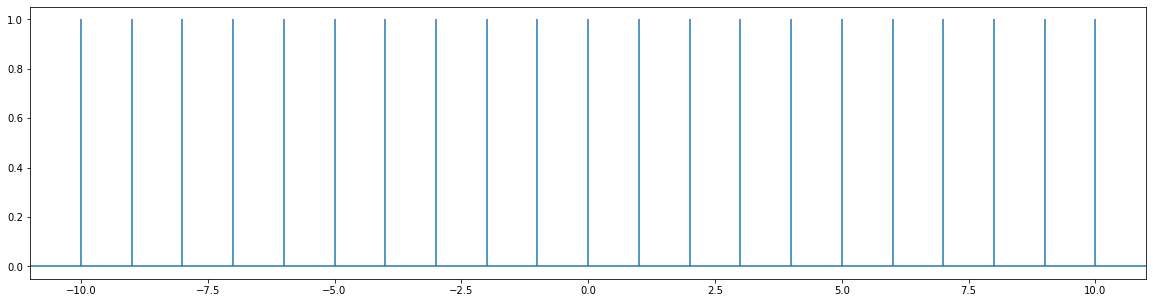

In [14]:
plt.figure(figsize=[20,5])
starttime = datetime.datetime(year=2019, month=3, day=1)
plt.acorr(df_aggregated['close'])

## Labeling Data

In [15]:
from scipy.signal import argrelextrema
import numpy as np

local_maximas_indices = argrelextrema(df_aggregated['close'].to_numpy(), np.greater)
local_minimas_indices = argrelextrema(df_aggregated['close'].to_numpy(), np.less)

In [16]:
print(len(df_aggregated['close'].iloc[local_maximas_indices].to_numpy()))
print(len(df_aggregated['close'].iloc[local_minimas_indices].to_numpy()))
sorted_indices = np.argsort(df_aggregated['close'].iloc[local_maximas_indices].to_numpy())
sorted_local_maximas_indices = local_maximas_indices[0][sorted_indices]

sorted_indices = np.argsort(df_aggregated['close'].iloc[local_minimas_indices].to_numpy())
sorted_local_minimas_indices = local_minimas_indices[0][sorted_indices]

4018
4020


In [17]:
df_aggregated['close'].iloc[sorted_local_maximas_indices]

2001-06-05 00:00:00    0.8454
2001-07-05 00:00:00    0.8461
2001-07-07 00:00:00    0.8469
2001-06-01 08:00:00    0.8472
2001-07-03 16:00:00    0.8475
                        ...  
2008-04-17 08:00:00    1.5971
2008-07-15 08:00:00    1.5973
2008-04-16 16:00:00    1.5974
2008-04-23 08:00:00    1.5975
2008-04-22 16:00:00    1.6006
Name: close, Length: 4018, dtype: float64

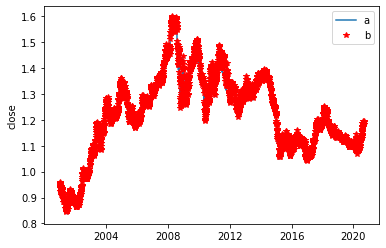

In [18]:
sns.lineplot(data=df_aggregated['close'])
plt.plot(df_aggregated.index[local_maximas_indices[:]], df_aggregated['close'].iloc[local_maximas_indices[:]], 'r*')
plt.legend(['a','b'])

In [19]:
df_aggregated['close']

2001-01-03 00:00:00    0.9507
2001-01-03 08:00:00    0.9490
2001-01-03 16:00:00    0.9460
2001-01-04 00:00:00    0.9283
2001-01-04 08:00:00    0.9426
                        ...  
2020-08-29 00:00:00    1.1901
2020-08-31 00:00:00    1.1916
2020-08-31 08:00:00    1.1893
2020-08-31 16:00:00    1.1949
2020-09-01 00:00:00    1.1937
Name: close, Length: 16318, dtype: float64

In [20]:
import torch
from torch.util.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

ModuleNotFoundError: No module named 'torch.util'